In [1]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox, probplot, norm
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
# https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff
# https://www.geeksforgeeks.org/python-how-and-where-to-apply-feature-scaling/
# https://medium.com/fintechexplained/ever-wondered-why-normal-distribution-is-so-important-110a482abee3
# https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51

In [2]:
train_data = pd.read_csv('dataset/train.csv')
test_data = pd.read_csv('dataset/test.csv')
all_data = pd.concat([train_data, test_data], ignore_index=True)

1.8828757597682129


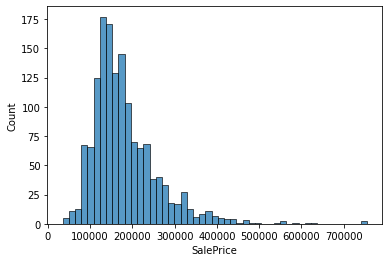

In [3]:
# visualizing data
sns.histplot(train_data['SalePrice'])
# sns.displot(data_train['SalePrice'], kind='hist')

# If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
# If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed
# If the skewness is less than -1 or greater than 1, the data are highly skewed
print(train_data['SalePrice'].skew())

<AxesSubplot:>

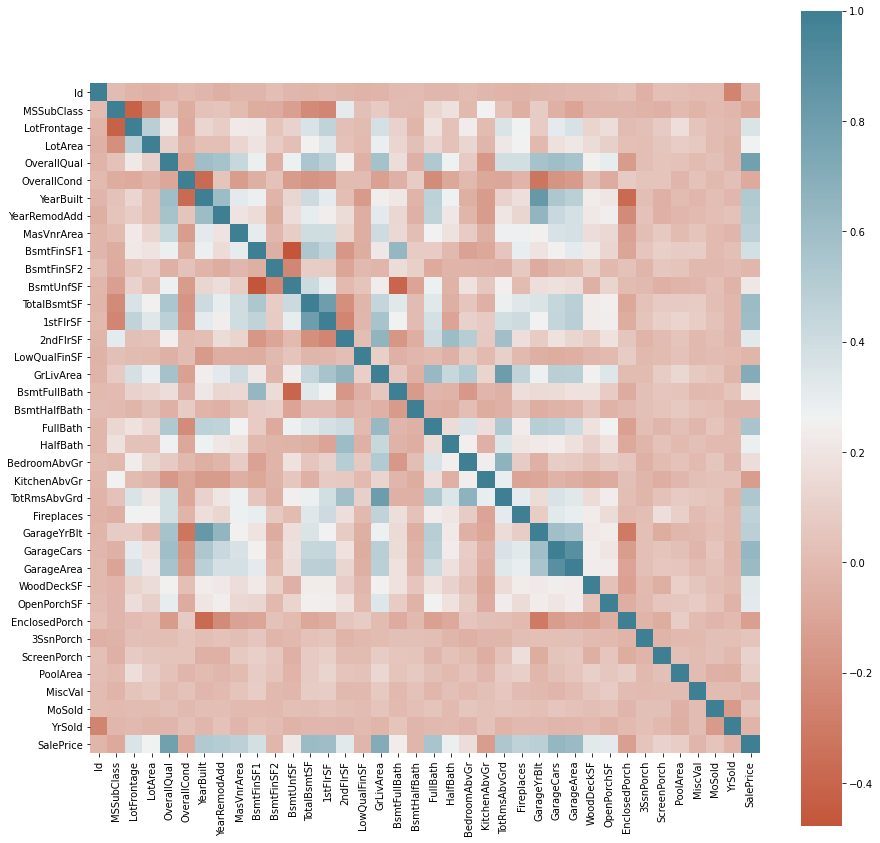

In [4]:
# 1 indicates a perfectly negative linear correlation between two variables
# 0 indicates no linear correlation between two variables
# 1 indicates a perfectly positive linear correlation between two variables

corrmat = all_data.corr()
plt.figure(figsize=(15, 15))
color_scheme = sns.diverging_palette(20, 220, n=200, as_cmap=True)
sns.heatmap(corrmat, cmap=color_scheme, square=True)

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
      dtype='object')


<AxesSubplot:>

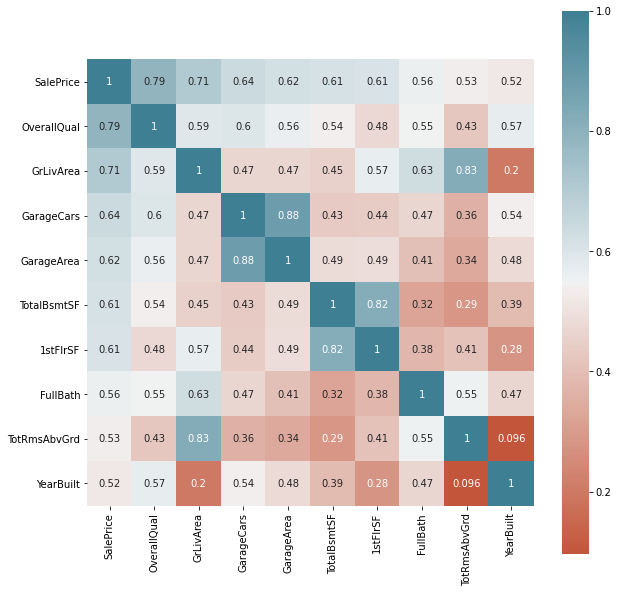

In [5]:
# based on the correlation heatmap, the sale price is more dependent on the following:
#    1. OverallQual
#    2. GrLiveArea
#    3. GarageCars
#    4. GarageArea
#    5. TotalBsmtSF
#    6. 1stFlrSF
# creating a correlation heatmap with these values
cols = corrmat.nlargest(10, 'SalePrice').index
print(cols)
new_cormat = np.corrcoef(train_data[cols].to_numpy().T)

plt.figure(figsize=(10, 10))
sns.heatmap(new_cormat, cmap=color_scheme, annot=True, square=True,
            yticklabels=cols.values, xticklabels=cols.values)

<AxesSubplot:xlabel='Neighborhood', ylabel='SalePrice'>

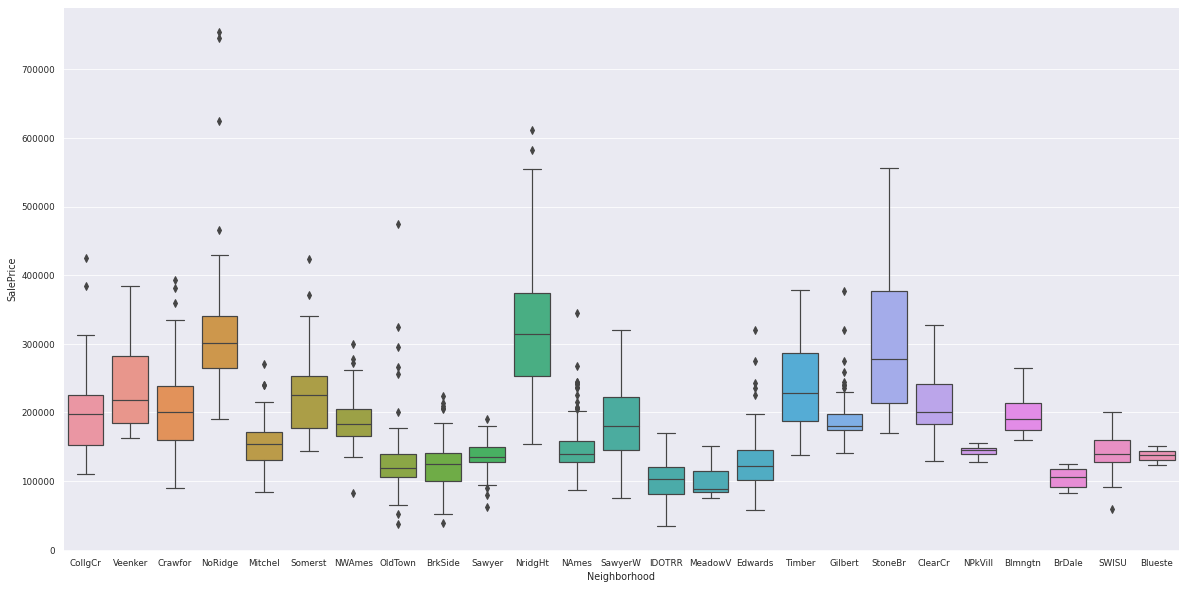

In [6]:
# plotting SalePrice vs Neighbourhood(location)
sns.set(rc={'figure.figsize': (20, 10)})
sns.set_context('paper')
sns.boxplot(x='Neighborhood', y='SalePrice', data=all_data)
# data_train['Neighborhood'].unique()
# data_train[data_train['Neighborhood'] == 'NoRidge']['SalePrice'].describe()

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

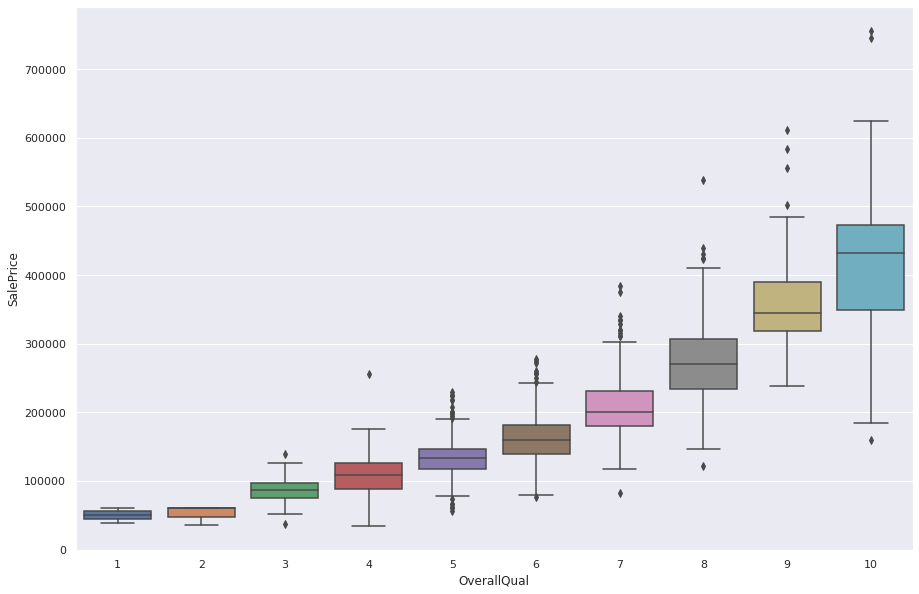

In [7]:
# plotting SalePrice vs OverallQual
sns.set(rc={'figure.figsize': (15, 10)})
sns.boxplot(x='OverallQual', y='SalePrice', data=all_data)

In [8]:
# taking a look at the missing(null) data
is_null = (all_data[all_data.columns.drop('SalePrice')]).isnull()
missing_total = is_null.sum().sort_values(ascending=False)
missing_total = missing_total[missing_total>0]
missing_percentage = (is_null.sum() * 100 / is_null.count()
                      ).sort_values(ascending=False)
missing_percentage = missing_percentage[missing_percentage>0]
missing_cols = pd.concat([missing_total, missing_percentage], keys=[
                         'Total', 'Percentage'], axis=1)
print(missing_cols.shape)
missing_cols.head(35)

(34, 2)


,Total,Percentage
PoolQC,2909,99.657417
MiscFeature,2814,96.402878
Alley,2721,93.216855
Fence,2348,80.438506
FireplaceQu,1420,48.646797
LotFrontage,486,16.649538
GarageYrBlt,159,5.447071
GarageFinish,159,5.447071
GarageQual,159,5.447071
GarageCond,159,5.447071


In [9]:
all_data = all_data.drop(
    columns=missing_cols[missing_cols['Percentage'] > 15].index)
# checking there are no missing values
print(all_data.shape)
print(all_data[all_data.columns.drop('SalePrice')].isnull().sum().max())

(2919, 75)
159


In [10]:
for col in ['GarageYrBlt', 'GarageCars', 'GarageArea']:
    all_data[col] = all_data[col].fillna(0)

In [11]:
for col in ['GarageFinish', 'GarageQual', 'GarageCond', 'GarageType']:
    all_data[col] = all_data[col].fillna('None')

In [12]:
for col in ['BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'BsmtHalfBath', 'BsmtFullBath']:
    all_data[col] = all_data[col].fillna(0)

In [13]:
for col in ['BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtExposure']:
    all_data[col] = all_data[col].fillna('None')

In [14]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [15]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [16]:
# all data are same ('AllPub') except one 'NoSeWa' and 2 'NA', so we'll drop this column
all_data = all_data.drop(columns='Utilities')

In [17]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [18]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna('TA')

In [19]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [20]:
for col in ['Exterior1st', 'Exterior2nd']:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [21]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [ ]:
# scaling SalePrice to identify outlieres
# saleprice_scaled = StandardScaler().fit_transform(train_data['SalePrice'][:, np.newaxis])
# saleprice_scaled = saleprice_scaled.reshape(1459, )
# lower_10, upper_10 = np.sort(saleprice_scaled)[:10], np.sort(saleprice_scaled)[-10:]
# sns.boxplot(x='SalePrice', y=None, data=train_data)
# print(lower_10)
# print(upper_10)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


1298    5642
2549    5095
523     4676
1182    4476
Name: GrLivArea, dtype: int64


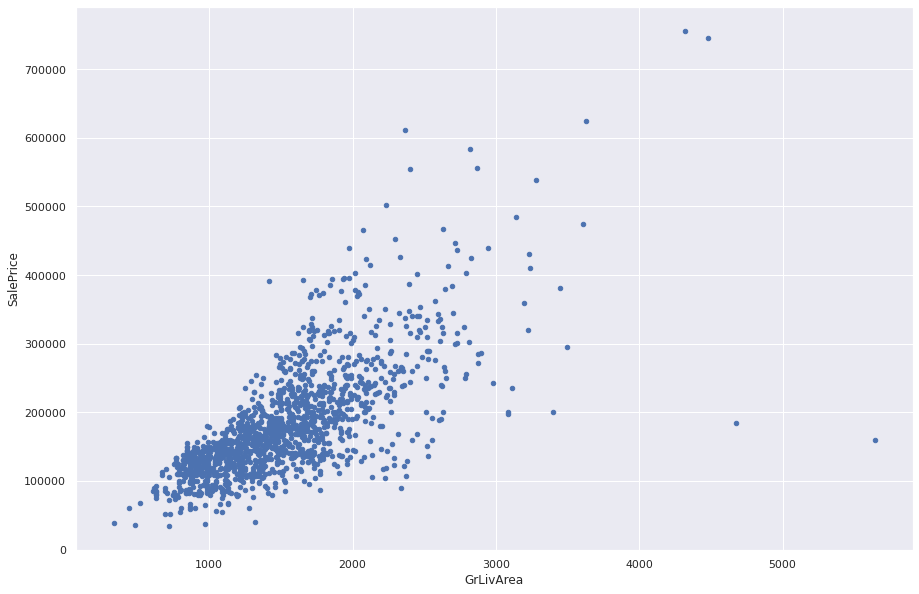

In [22]:
# plotting data to outliers and remove
all_data.plot.scatter(x='GrLivArea', y='SalePrice')
# 2 outliers in the rightmost bottom
print(all_data['GrLivArea'].sort_values(ascending=False)[:4])
all_data = all_data.drop(all_data[all_data['GrLivArea'] > 5642].index)

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

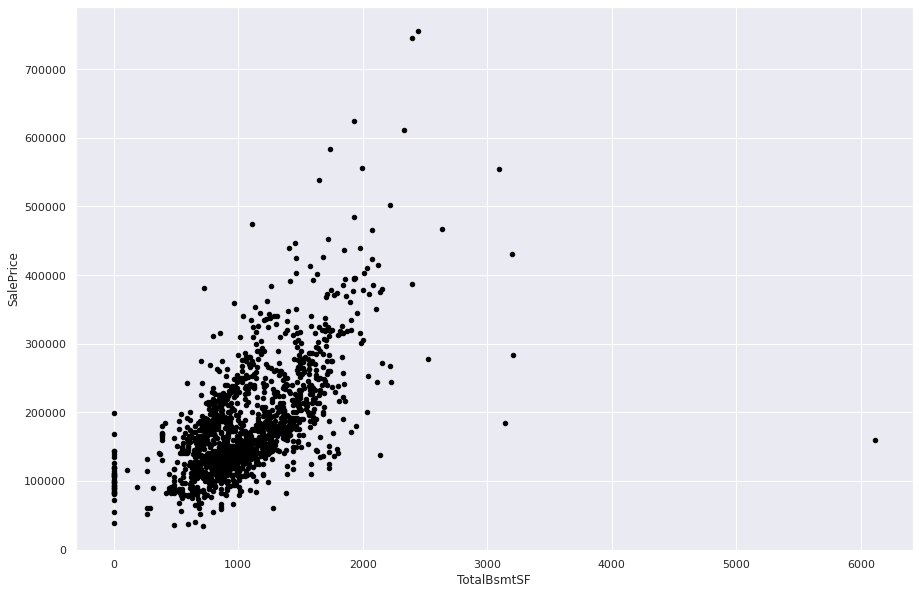

In [23]:
all_data.plot.scatter(x='TotalBsmtSF', y='SalePrice', c='black')
# 5 outliers TotalBsmtSF > 3000

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

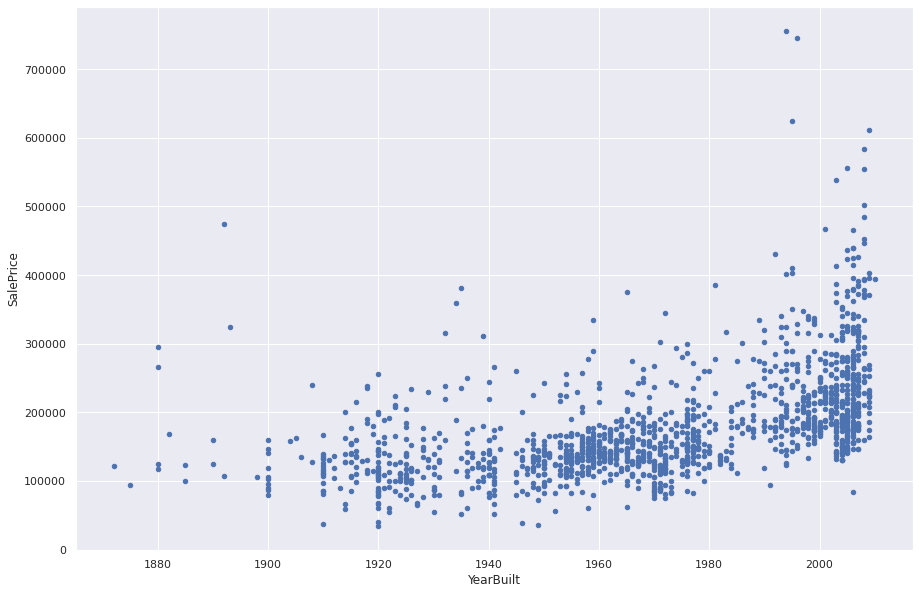

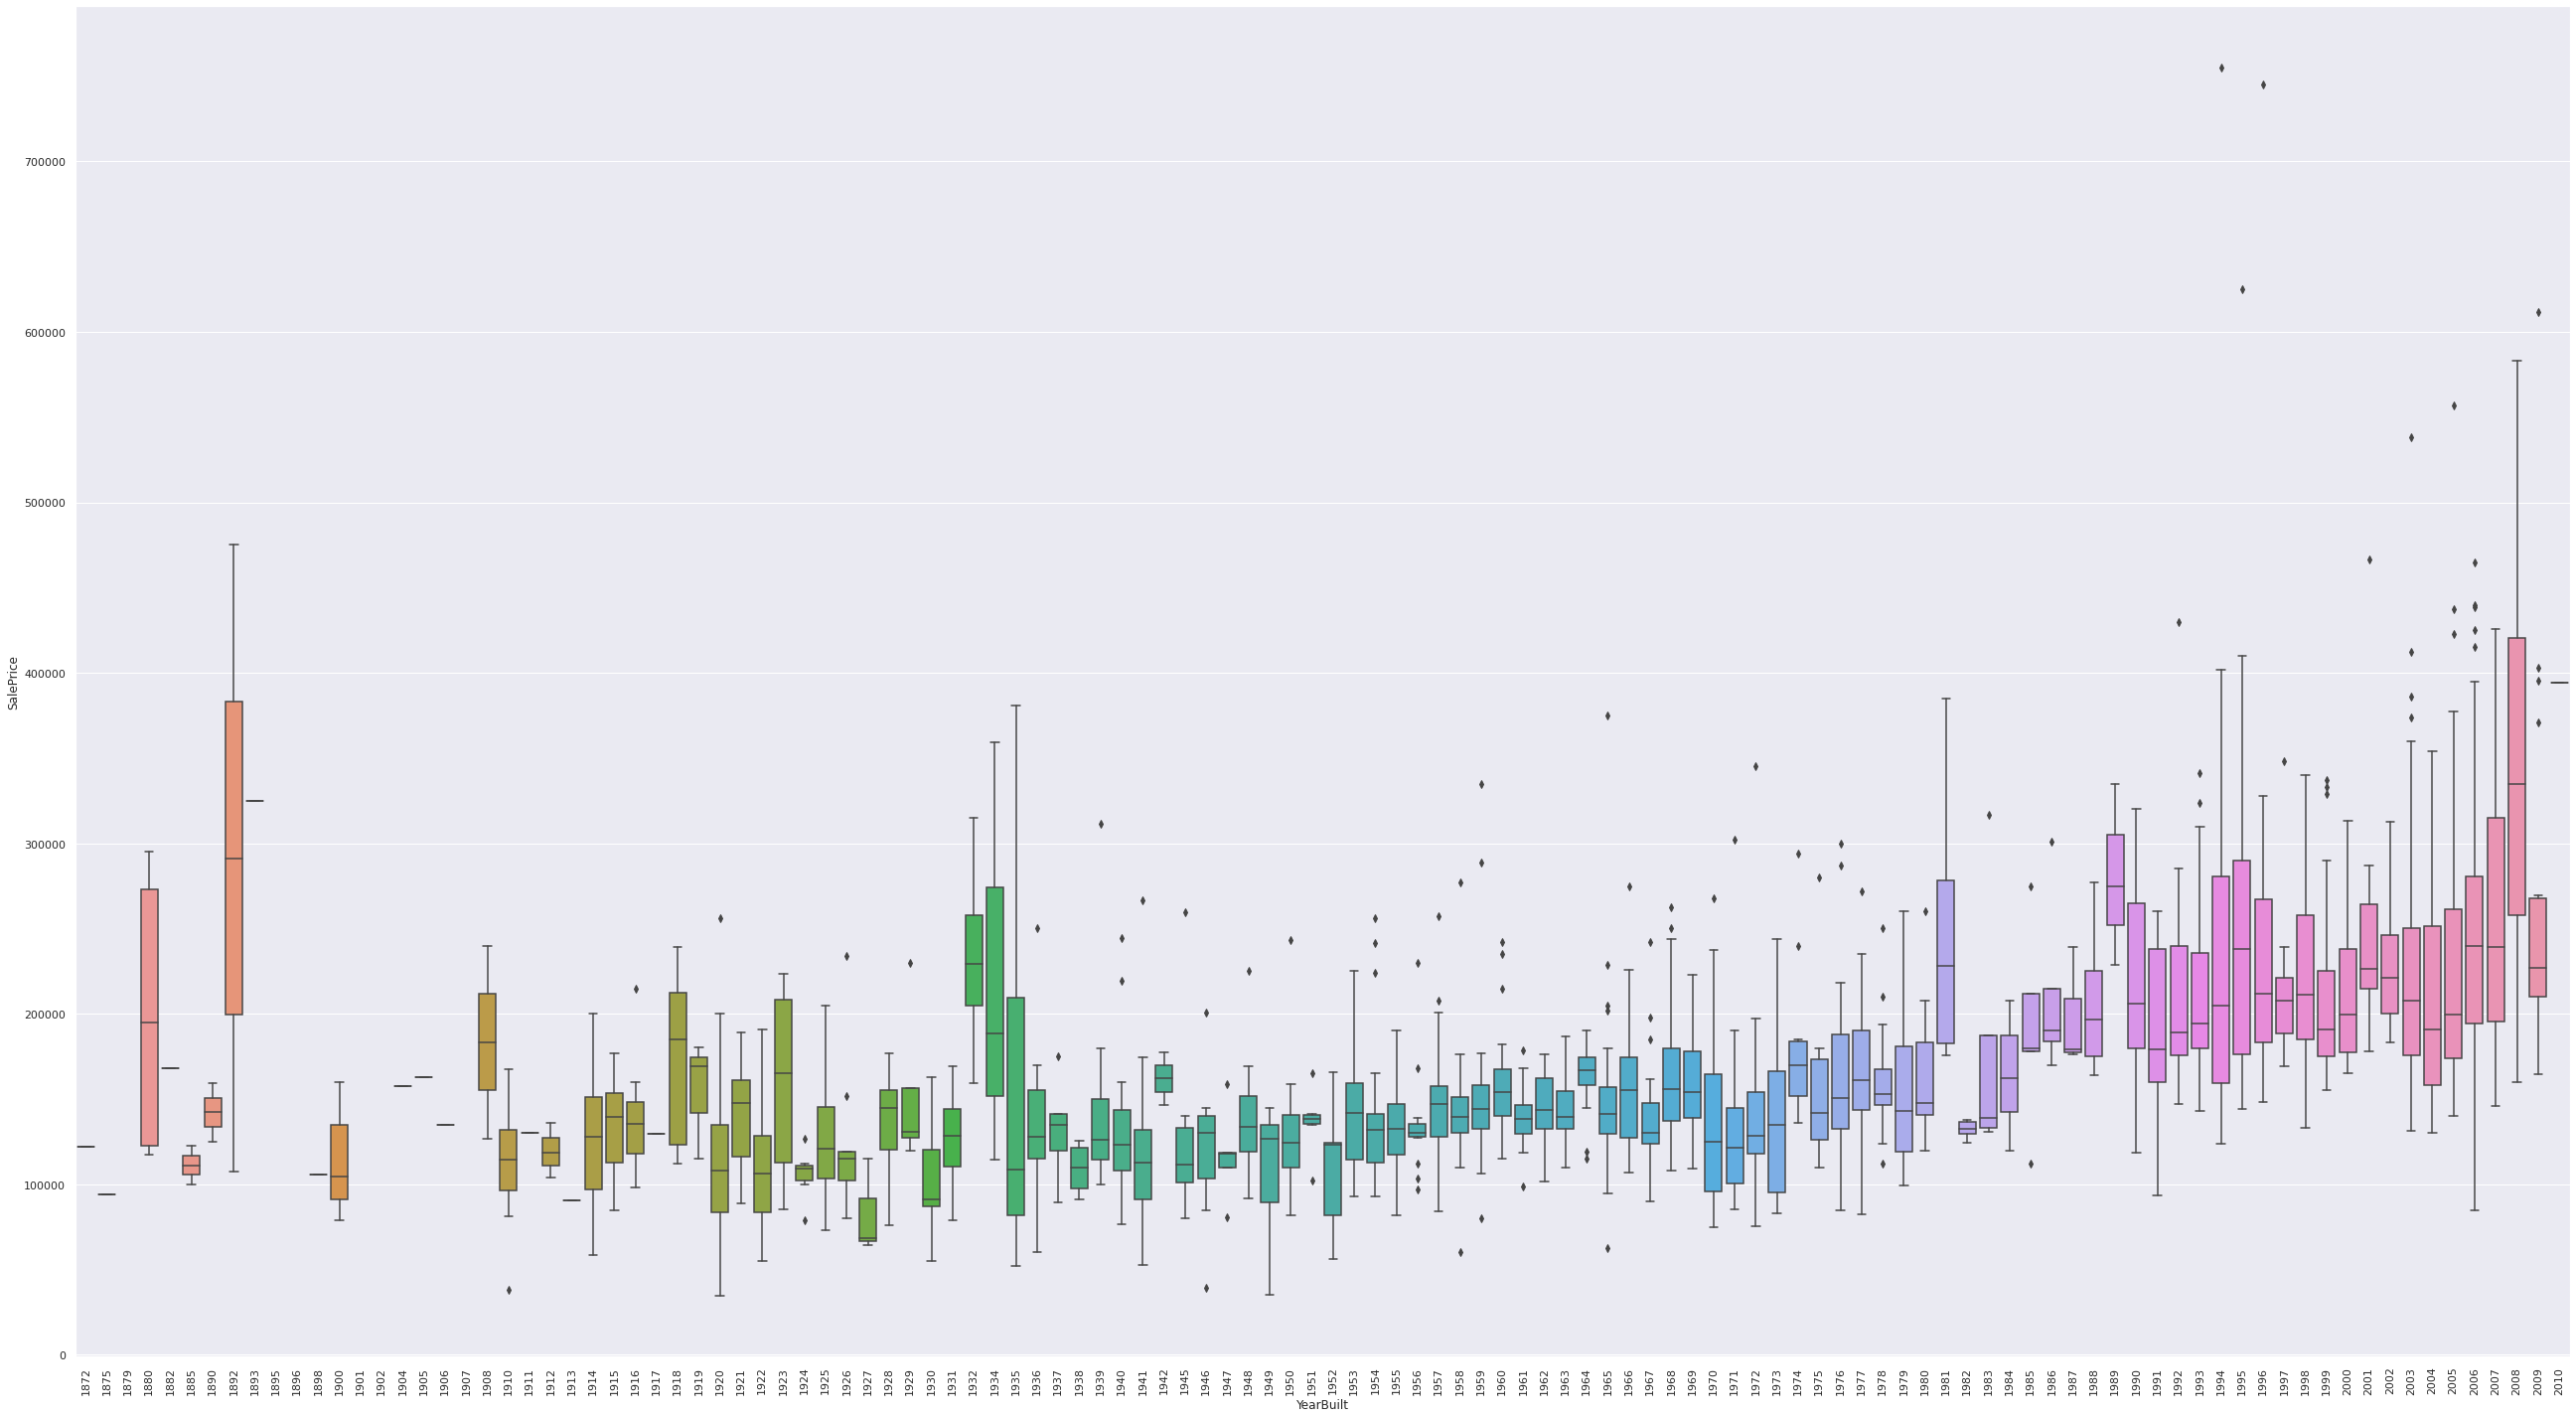

In [24]:
all_data.plot.scatter(x='YearBuilt', y='SalePrice')
plt.figure(figsize=(45, 25))
plt.xticks(rotation=90)
sns.boxplot(x='YearBuilt', y='SalePrice', data=all_data)

In [25]:
# dropping outliers with SalePrice > 600000 and YearBuilt > 1993
all_data = all_data.drop(all_data[np.logical_and(
    (all_data['YearBuilt'] > 1993), (all_data['SalePrice'] > 600000))].index)

In [26]:
numeric_features = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_data = all_data[numeric_features].skew().sort_values(ascending=False)
print(skewed_data.head(20))

MiscVal          21.943440
PoolArea         17.785129
LotArea          12.900799
LowQualFinSF     12.086535
3SsnPorch        11.373947
KitchenAbvGr      4.301059
BsmtFinSF2        4.144996
EnclosedPorch     4.002856
ScreenPorch       3.945539
BsmtHalfBath      3.944922
MasVnrArea        2.545001
OpenPorchSF       2.536458
WoodDeckSF        1.849315
1stFlrSF          1.471120
SalePrice         1.427011
BsmtFinSF1        1.421465
MSSubClass        1.375309
GrLivArea         1.182706
TotalBsmtSF       1.155205
BsmtUnfSF         0.919649
dtype: float64


In [27]:
# applying log transformation on the data
# sns.distplot(saleprice_scaled, fit=norm)
# plt.figure()
# sns.distplot(boxcox(data_train['SalePrice'])[0], fit=norm)
# plt.figure()
# probplot(boxcox(data_train['SalePrice'])[0], plot=plt)
# all_data = all_data.drop(columns=['Id'])
train_index = all_data.apply(pd.Series.last_valid_index)['SalePrice']
print(train_index)

1459


In [28]:
all_data = pd.get_dummies(all_data)
train_data = all_data.loc[:train_index]
y_train = train_data['SalePrice']
x_train = train_data.drop(columns='SalePrice')
x_test = all_data.loc[train_index+1:]
x_test = x_test.drop(columns='SalePrice')
x_test.reset_index(drop=True, inplace=True)

In [29]:
print(y_train.isnull().sum())
print(y_train.shape, x_train.shape, x_test.shape)

0
(1456,) (1456, 277) (1459, 277)


In [37]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet

lasso = Lasso(alpha=0.1)
linear = LinearRegression()
elasticnet = ElasticNet()

lasso.fit(x_train, y_train)
linear.fit(x_train, y_train)
elasticnet.fit(x_train, y_train)

ElasticNet()

In [38]:
sub = pd.DataFrame()
sub['Id'] = test_data['Id']
for model in [lasso, linear, elasticnet]:
    sub['SalePrice'] = model.predict(x_test)
    sub.to_csv('{}.csv'.format(model.__class__.__name__), index=False)